In [1]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
import faiss
import os, io, pickle
from langchain.chains import RetrievalQA
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
    SpacyTextSplitter
)
from langchain.vectorstores import FAISS
import numpy as np
import pandas as pd
import tiktoken
from sentence_transformers import SentenceTransformer
import shutil
import statistics
import json
import os
from dotenv import load_dotenv

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

def authenticate_google():
    creds = None
    if os.path.exists("token"):
        with open("token", "rb") as token:
            creds = pickle.load(token)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("credentials3.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token", "wb") as token:
            pickle.dump(creds, token)
    
    return build("drive", "v3", credentials=creds)

def download_pdf(file_id, output_path):
    service = authenticate_google()
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(output_path, "wb")
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Téléchargement : {int(status.progress() * 100)}%")
    print(f"Fichier téléchargé : {output_path}")


file_id = "1AHE1lXi_kyrtRw31qEGJ7OYE9EO8kfGe"
download_pdf(file_id, "Histoire_CM1.pdf")

Téléchargement : 100%
Fichier téléchargé : Histoire_CM1.pdf


In [3]:
# Fonction pour estimer le nombre de tokens d’un texte
def count_tokens(text, model="gpt-3.5-turbo"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

In [4]:
# Charger ton PDF
loader = PyPDFLoader("Histoire_CM1.pdf",
                     mode = "page", # Extract the PDF by page. Each page is extracted as a langchain Document object
                     # mode = "single" # PyPDFLoader will split the PDF as a single text flow
                     )
docs = loader.load()

In [5]:
full_text = "\n".join([page.page_content for page in docs])
full_text

'LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  \n \n \n1)  Qu’est-ce que l’Histoire ? \n \n*L’Histoire est l’étude de notre passé  pour mieux \ncomprendre notre vie aujourd’hui. \n \n *Pour découvrir notre passé, les historiens font des fouilles \narchéologiques, étudient des objets, des documents, des récits…  \n*Ils représentent le temps par une ligne graduée  : c’est la frise \nchronologique.  \n \n*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient \nl’Histoire.  \n*L’Histoire de France est divisée en 5 périodes : \nl’Antiquité – le Moyen Âge – les Temps Modernes – le XIX ème \nsiècle – le XXème siècle. \n \n \n \n \n2) Des traces du passé : les grottes ornées \n \n*En 1940, 4 enfants découvrent une grotte recouverte \nde peintures  : des taureaux, des cerfs, des chevaux…  : \nla grotte de Lascaux.  En datant les objets trouvés dans la grotte on \nsait qu’elle a été peinte il y a environ 17000 ans.  \n \n*En 1994, Jean -Marie Chauvet découvre une autre grotte pei

In [6]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_text(full_text)
token_counts = [count_tokens(chunk) for chunk in chunks]

print(f"Nombre de chunks : {len(chunks)}")
print(f"Tokens/chunk (moy) : {round(statistics.mean(token_counts))}")
print(f"Tokens max : {max(token_counts)}")
print(f"Aperçu du 1er chunk :\n{chunks[0]}")


Nombre de chunks : 27
Tokens/chunk (moy) : 144
Tokens max : 161
Aperçu du 1er chunk :
LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  
 
 
1)  Qu’est-ce que l’Histoire ? 
 
*L’Histoire est l’étude de notre passé  pour mieux 
comprendre notre vie aujourd’hui. 
 
 *Pour découvrir notre passé, les historiens font des fouilles 
archéologiques, étudient des objets, des documents, des récits…  
*Ils représentent le temps par une ligne graduée  : c’est la frise 
chronologique.  
 
*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient 
l’Histoire.


In [7]:
chunks

['LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  \n \n \n1)  Qu’est-ce que l’Histoire ? \n \n*L’Histoire est l’étude de notre passé  pour mieux \ncomprendre notre vie aujourd’hui. \n \n *Pour découvrir notre passé, les historiens font des fouilles \narchéologiques, étudient des objets, des documents, des récits…  \n*Ils représentent le temps par une ligne graduée  : c’est la frise \nchronologique.  \n \n*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient \nl’Histoire.',
 'l’Histoire.  \n*L’Histoire de France est divisée en 5 périodes : \nl’Antiquité – le Moyen Âge – les Temps Modernes – le XIX ème \nsiècle – le XXème siècle. \n \n \n \n \n2) Des traces du passé : les grottes ornées \n \n*En 1940, 4 enfants découvrent une grotte recouverte \nde peintures  : des taureaux, des cerfs, des chevaux…  : \nla grotte de Lascaux.  En datant les objets trouvés dans la grotte on \nsait qu’elle a été peinte il y a environ 17000 ans.',
 '*En 1994, Jean -Marie Chauvet découvre une a

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(chunks)

print("Taille des embeddings : ", embeddings.shape)
for i, (chunk, emb) in enumerate(zip(chunks, embeddings)):
    print("="*60)
    print(f"Chunk {i+1}:")
    print(chunk)
    print(f"\n Embedding (taille {len(emb)}):")
    print(np.round(emb[:10], 3))  # Affiche les 10 premières valeurs, arrondies pour lisibilité
    print("="*60)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1520: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Taille des embeddings :  (27, 384)
Chunk 1:
LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  
 
 
1)  Qu’est-ce que l’Histoire ? 
 
*L’Histoire est l’étude de notre passé  pour mieux 
comprendre notre vie aujourd’hui. 
 
 *Pour découvrir notre passé, les historiens font des fouilles 
archéologiques, étudient des objets, des documents, des récits…  
*Ils représentent le temps par une ligne graduée  : c’est la frise 
chronologique.  
 
*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient 
l’Histoire.

 Embedding (taille 384):
[-0.024  0.15   0.059 -0.052 -0.017  0.151 -0.052  0.037 -0.035  0.003]
Chunk 2:
l’Histoire.  
*L’Histoire de France est divisée en 5 périodes : 
l’Antiquité – le Moyen Âge – les Temps Modernes – le XIX ème 
siècle – le XXème siècle. 
 
 
 
 
2) Des traces du passé : les grottes ornées 
 
*En 1940, 4 enfants découvrent une grotte recouverte 
de peintures  : des taureaux, des cerfs, des chevaux…  : 
la grotte de Lascaux.  En datant les objets trouvés d

In [9]:
embeddings

array([[-0.02409801,  0.15005709,  0.05920077, ...,  0.09878287,
         0.0695245 , -0.00646508],
       [-0.03620609,  0.09299161,  0.03982632, ...,  0.06420294,
         0.05219615, -0.02919059],
       [-0.01901925,  0.08690844,  0.00442928, ...,  0.03393076,
         0.02795276, -0.06976099],
       ...,
       [-0.02227543, -0.01261734,  0.05541164, ...,  0.06810159,
         0.02536621, -0.10883665],
       [-0.06239758, -0.00572261, -0.04367066, ...,  0.1075111 ,
         0.03162517, -0.11246725],
       [-0.03342411,  0.01745189, -0.09395038, ...,  0.05312137,
         0.06219157, -0.08289981]], dtype=float32)

In [10]:
for chunk in chunks:
    print(chunk)
    print("")
    print("---")
    print("")

LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  
 
 
1)  Qu’est-ce que l’Histoire ? 
 
*L’Histoire est l’étude de notre passé  pour mieux 
comprendre notre vie aujourd’hui. 
 
 *Pour découvrir notre passé, les historiens font des fouilles 
archéologiques, étudient des objets, des documents, des récits…  
*Ils représentent le temps par une ligne graduée  : c’est la frise 
chronologique.  
 
*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient 
l’Histoire.

---

l’Histoire.  
*L’Histoire de France est divisée en 5 périodes : 
l’Antiquité – le Moyen Âge – les Temps Modernes – le XIX ème 
siècle – le XXème siècle. 
 
 
 
 
2) Des traces du passé : les grottes ornées 
 
*En 1940, 4 enfants découvrent une grotte recouverte 
de peintures  : des taureaux, des cerfs, des chevaux…  : 
la grotte de Lascaux.  En datant les objets trouvés dans la grotte on 
sait qu’elle a été peinte il y a environ 17000 ans.

---

*En 1994, Jean -Marie Chauvet découvre une autre grotte peinte il y 


In [11]:
len(chunks)

27

In [12]:
df = pd.DataFrame(chunks, columns=['string'])
df

,string
0,LLeeççoonnss dd’’hhiissttooiirree CCMM11 ...
1,l’Histoire. \n*L’Histoire de France est divis...
2,"*En 1994, Jean -Marie Chauvet découvre une aut..."
3,surtout des rennes dont il utilise tous les él...
4,font souvent la guerre. \n \n*Ils vivent dans...
5,les Gallo-Romains et vivent en paix. \n \n*Il...
6,peuples venus de l’est . Ils s’ installent en ...
7,"empereur en l’an 800. \n \n*A sa mort, l’empi..."
8,mieux équipées pour se défendre contre les enn...
9,"sacrements religieux (baptême, mariage, confir..."


In [13]:
df['string_clean'] = df['string'].str.replace(r"<[^>]*>", " ", regex=True)
df['string_clean'] = df['string_clean'].str.replace(r"[^A-Za-zÀ-ÿ0-9\s ]+", " ", regex = True)
df['string_clean'] = df['string_clean'].str.replace(r"\s+", " ", regex = True)
df['string_clean'] = df['string_clean'].fillna('').apply(lambda x: x.lower())
df

,string,string_clean
0,LLeeççoonnss dd’’hhiissttooiirree CCMM11 ...,lleeççoonnss dd hhiissttooiirree ccmm11 1 qu e...
1,l’Histoire. \n*L’Histoire de France est divis...,l histoire l histoire de france est divisée en...
2,"*En 1994, Jean -Marie Chauvet découvre une aut...",en 1994 jean marie chauvet découvre une autre...
3,surtout des rennes dont il utilise tous les él...,surtout des rennes dont il utilise tous les él...
4,font souvent la guerre. \n \n*Ils vivent dans...,font souvent la guerre ils vivent dans des fer...
5,les Gallo-Romains et vivent en paix. \n \n*Il...,les gallo romains et vivent en paix ils constr...
6,peuples venus de l’est . Ils s’ installent en ...,peuples venus de l est ils s installent en gau...
7,"empereur en l’an 800. \n \n*A sa mort, l’empi...",empereur en l an 800 a sa mort l empire est di...
8,mieux équipées pour se défendre contre les enn...,mieux équipées pour se défendre contre les enn...
9,"sacrements religieux (baptême, mariage, confir...",sacrements religieux baptême mariage confirmat...


In [14]:
import fr_core_news_sm
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOPS

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = fr_core_news_sm.load()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
nlp

In [16]:
df['string_token_temp'] = df['string_clean'].apply(
    lambda x: [token.lemma_ for token in nlp(x) if token.text.lower() not in FR_STOPS]
)
df['nlp_ready_temp'] = df['string_token_temp'].apply(lambda x: ' '.join(x))

vectorizer_temp = TfidfVectorizer(stop_words=None)
X_temp = vectorizer_temp.fit_transform(df['nlp_ready_temp'])
feature_names = vectorizer_temp.get_feature_names_out()
mean_tfidf = X_temp.mean(axis=0).A1

vec = CountVectorizer()
X_count = vec.fit_transform(df['nlp_ready_temp'])
doc_freq = np.asarray(X_count.sum(axis=0)).ravel() / X_count.shape[0]
words_high_freq = [word for word, freq in zip(vec.get_feature_names_out(), doc_freq) if freq > 0.7]

threshold = 0.008
low_info_words = [word for word, score in zip(feature_names, mean_tfidf) if score < threshold]

combined_stopwords = STOP_WORDS.union(set(low_info_words)).union(set(words_high_freq))

df['string_token'] = df['string_clean'].apply(
    lambda x: [token.lemma_ for token in nlp(x)
            if token.text.lower() not in combined_stopwords
            and token.lemma_.lower() not in combined_stopwords]
)
df['nlp_ready'] = df['string_token'].apply(lambda x: ' '.join(x))

final_vectorizer = TfidfVectorizer(stop_words=None)
X = final_vectorizer.fit_transform(df['nlp_ready'])
X

<27x173 sparse matrix of type '<class 'numpy.float64'>'
	with 464 stored elements in Compressed Sparse Row format>

In [22]:

def auto_svd_dim(X, target_var=0.7, min_dim=5, max_dim=300):
    # X = matrice TF-IDF (sparse)
    max_rank = min(X.shape[0]-1, X.shape[1]-1)           # limite mathématique
    probe = min(max_dim, max_rank)                       # SVD d'exploration
    svd_probe = TruncatedSVD(n_components=max(2, probe), random_state=42)
    svd_probe.fit(X)
    cumvar = np.cumsum(svd_probe.explained_variance_ratio_)

    # plus petite dim qui atteint le seuil
    k = int(np.searchsorted(cumvar, target_var) + 1)
    k = max(min_dim, min(k, probe))                      # bornes
    return k

# usage
k = auto_svd_dim(X, target_var=0.7, min_dim=5, max_dim=300)
svd = TruncatedSVD(n_components=k, random_state=42)
svd.fit(X)

TruncatedSVD(n_components=15, random_state=42)

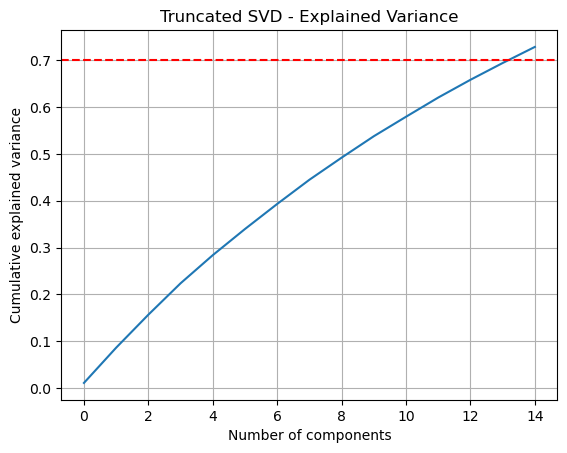

In [23]:
explained = np.cumsum(svd.explained_variance_ratio_)

plt.plot(explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid()
plt.title("Truncated SVD - Explained Variance")
plt.axhline(0.70, color='red', linestyle='--')
plt.show()

In [ ]:
svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100)
lsa = svd_model.fit_transform(X)
lsa

In [25]:

svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100)
lsa = svd_model.fit_transform(X)
lsa

array([[ 1.29491862e-01,  3.00229461e-01, -2.55728897e-01,
         3.39447444e-01,  8.87406404e-02, -1.78439788e-01,
         3.78733220e-02,  1.30760574e-01, -2.31745433e-01,
         1.17202572e-01,  5.18865892e-01,  1.48826828e-01,
        -2.11097426e-01, -3.42352726e-01, -7.64671162e-02],
       [ 2.36680442e-01,  4.48449942e-01, -3.51391995e-01,
         4.80474599e-01,  1.61111357e-01, -2.98283058e-01,
        -5.62846568e-02,  9.16463751e-02, -1.56785666e-01,
         6.65643325e-02,  6.46734975e-03,  1.11025220e-01,
        -1.18790083e-02,  9.74460376e-02, -1.05026874e-02],
       [ 1.95294458e-01,  3.99481718e-01, -1.61553290e-01,
         3.75362236e-01,  3.13098106e-01, -2.73319841e-01,
        -1.92838961e-01, -5.40859904e-02,  3.93719606e-02,
        -1.03537737e-01, -3.77193755e-01, -4.73827004e-02,
         1.64394251e-01,  2.74312685e-01,  1.13371425e-02],
       [ 2.29891933e-01,  3.63359212e-01,  3.30404213e-01,
        -1.12286413e-01,  1.83818462e-01, -2.10326214

In [28]:
topic_df = pd.DataFrame(lsa, columns=["topic {}".format(i+1) for i in range(k)], index=df.index)
topic_df['string'] = df['nlp_ready'].values
topic_df

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15,string
0,0.129492,0.300229,-0.255729,0.339447,0.088741,-0.178440,0.037873,0.130761,-0.231745,0.117203,0.518866,0.148827,-0.211097,-0.342353,-0.076467,1 l histoire l histoire l passé mieux vie aujo...
1,0.236680,0.448450,-0.351392,0.480475,0.161111,-0.298283,-0.056285,0.091646,-0.156786,0.066564,0.006467,0.111025,-0.011879,0.097446,-0.010503,l histoire l histoire france diviser 5 l antiq...
2,0.195294,0.399482,-0.161553,0.375362,0.313098,-0.273320,-0.192839,-0.054086,0.039372,-0.103538,-0.377194,-0.047383,0.164394,0.274313,0.011337,chauvet découvrir grotte peindre an grotte c...
3,0.229892,0.363359,0.330404,-0.112286,0.183818,-0.210326,0.148692,-0.353420,0.354036,-0.144964,0.164896,-0.281933,-0.030909,-0.071839,0.234909,utiliser c artisan outil pierre l nomade 4 gau...
4,0.348385,0.495905,0.473912,-0.292577,0.221439,-0.134484,0.189866,-0.036414,0.080003,-0.084476,0.046800,0.072895,0.043886,-0.178294,0.035100,guerre vivre aujourd artisan créer outil inven...
5,0.401278,0.330432,0.364889,-0.326146,0.015508,0.087071,0.016444,0.245182,-0.186028,0.008453,-0.095277,0.402516,0.139896,-0.032297,-0.126172,gallo romain vivre voir romain créer ville rel...
6,0.360825,0.319571,0.243335,-0.022105,-0.267720,0.131960,-0.011528,0.084492,0.040802,0.151250,0.028229,-0.116603,-0.394681,0.340166,-0.125099,peuple venir l s installer gaule l empire roma...
7,0.309110,0.242014,-0.020538,0.239727,-0.450499,0.312192,0.205019,-0.351960,-0.085494,-0.035699,-0.091600,0.066148,-0.071243,-0.011449,0.009609,empereur l an 800 mort l empire diviser fils p...
8,0.283950,0.230522,-0.200153,0.265369,-0.445546,0.356455,0.101413,-0.188681,0.016692,-0.173737,-0.221914,0.051617,-0.044639,-0.122329,0.128046,mieux équiper contre l protéger château seigne...
9,0.152949,0.116776,-0.105593,0.077639,-0.292565,-0.057948,-0.103349,0.540943,0.277520,-0.066308,0.144443,-0.404938,0.013786,-0.117369,0.079487,religieux clergé l moine livre main d livre be...


In [41]:
import hdbscan
from sklearn.preprocessing import normalize
X = normalize(lsa)

n = len(X)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size = max(3, n//50),   # ex: 3–10
    min_samples = 1,                    # plus permissif au début
    metric = 'euclidean',               # après normalisation
    cluster_selection_method='leaf',    # plus granulaire
    cluster_selection_epsilon=0.05      # relaxe un peu la coupe
)
labels = clusterer.fit_predict(X)

# Création d’un DataFrame avec résultats
df_hdbscan = df.copy()
df_hdbscan = df_hdbscan.drop(
    columns=['string_clean', 'string_token_temp', 'nlp_ready_temp', 'string_token']
)
df_hdbscan['hdb_cluster'] = labels

# Aperçu
print(df_hdbscan.sample(10))

# Compte des clusters
print(df_hdbscan['hdb_cluster'].value_counts())

                                               string  \
19  le clergé, la noblesse et le Tiers Etat.  \n \...   
8   mieux équipées pour se défendre contre les enn...   
25  *Napoléon perd la bataille de Waterloo contre ...   
7   empereur en l’an 800.  \n \n*A sa mort, l’empi...   
4   font souvent la guerre.  \n \n*Ils vivent dans...   
6   peuples venus de l’est . Ils s’ installent en ...   
23  autre gouvernement est mis en place.  \n \n*Il...   
22  *privilège : avantage que quelqu’un a sur quel...   
16  Vinci en France.  \n \n*Il emmène sa cour  dan...   
24  les lycées…  \n \n*Il se fait sacrer empereur ...   

                                            nlp_ready  hdb_cluster  
19  clergé tiers etat tiers etat payer l impôt fra...            1  
8   mieux équiper contre l protéger château seigne...            1  
25    napoléon perdre contre 1815 pouvoir 22 révol...            1  
7   empereur l an 800 mort l empire diviser fils p...            1  
4   guerre vivre aujourd ar

In [42]:
df_hdbscan

,string,nlp_ready,hdb_cluster
0,LLeeççoonnss dd’’hhiissttooiirree CCMM11 ...,1 l histoire l histoire l passé mieux vie aujo...,0
1,l’Histoire. \n*L’Histoire de France est divis...,l histoire l histoire france diviser 5 l antiq...,0
2,"*En 1994, Jean -Marie Chauvet découvre une aut...",chauvet découvrir grotte peindre an grotte c...,0
3,surtout des rennes dont il utilise tous les él...,utiliser c artisan outil pierre l nomade 4 gau...,3
4,font souvent la guerre. \n \n*Ils vivent dans...,guerre vivre aujourd artisan créer outil inven...,3
5,les Gallo-Romains et vivent en paix. \n \n*Il...,gallo romain vivre voir romain créer ville rel...,3
6,peuples venus de l’est . Ils s’ installent en ...,peuple venir l s installer gaule l empire roma...,1
7,"empereur en l’an 800. \n \n*A sa mort, l’empi...",empereur l an 800 mort l empire diviser fils p...,1
8,mieux équipées pour se défendre contre les enn...,mieux équiper contre l protéger château seigne...,1
9,"sacrements religieux (baptême, mariage, confir...",religieux clergé l moine livre main d livre be...,3


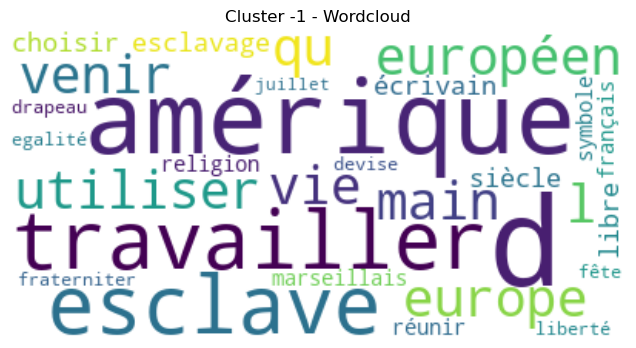

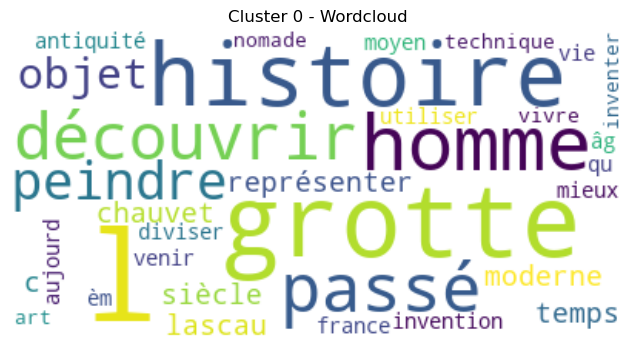

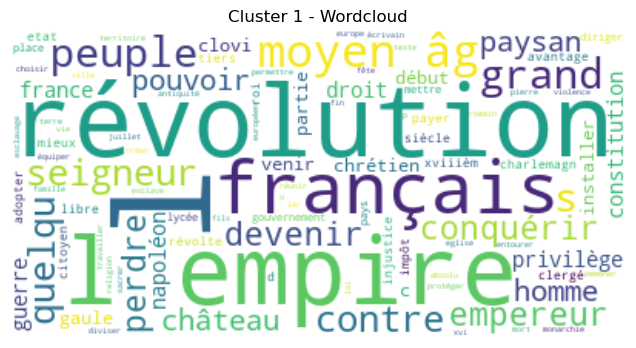

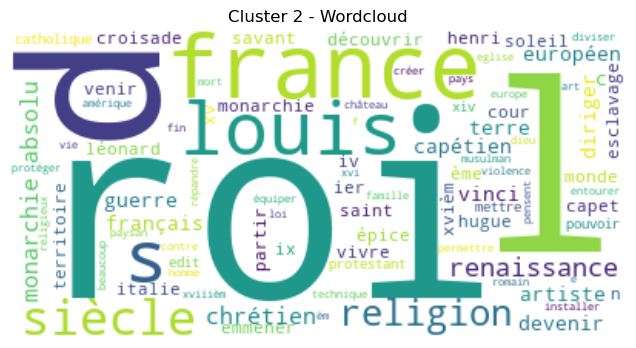

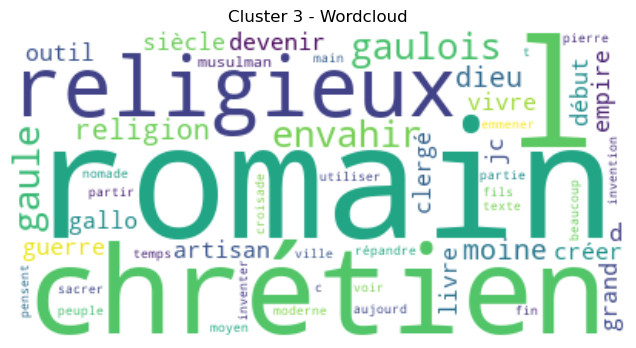

In [44]:
for i in sorted(df_hdbscan['hdb_cluster'].unique()):
    text = " ".join(df_hdbscan[df_hdbscan['hdb_cluster'] == i]['nlp_ready'])
    wordcloud = WordCloud(background_color='white').generate(text)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {i} - Wordcloud")
    plt.show()

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

top_words_per_cluster = {}

for cluster_id in df_hdbscan['hdb_cluster'].unique():
    if cluster_id == -1:  # on ignore le bruit
        continue
    
    # Texte du cluster
    cluster_texts = df_hdbscan[df_hdbscan['hdb_cluster'] == cluster_id]['nlp_ready']
    
    # Vectorisation
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(cluster_texts)
    
    # Somme des fréquences
    word_counts = X.sum(axis=0)
    words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    # Top 3
    top_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:3]
    top_words_per_cluster[cluster_id] = [w for w, _ in top_words]
top_words_per_cluster
# Résultat
#pd.DataFrame(list(top_words_per_cluster.items()), columns=['cluster', 'top_3_words'])


{0: ['grotte', 'histoire', 'homme'],
 3: ['romain', 'chrétien', 'religieux'],
 1: ['révolution', 'empire', 'moyen'],
 2: ['roi', 'france', 'monarchie']}

In [68]:
for theme_id, words in top_words_per_cluster.items():
    string = ' '.join(words)
    print(string)




grotte histoire homme
romain chrétien religieux
révolution empire moyen
roi france monarchie


In [9]:
import shutil
import os

chroma_db_path = "chroma_db"

if os.path.exists(chroma_db_path):
    shutil.rmtree(chroma_db_path)

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
documents = [Document(page_content=chunk, metadata={"chunk_id": i}) for i, chunk in enumerate(chunks)]

chroma_db = Chroma.from_documents(
    documents, 
    embedding_model, 
    persist_directory = chroma_db_path)

/tmp/ipykernel_1780/1402809748.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [10]:
vector_db_data = chroma_db.get()
len(vector_db_data['ids'])

27

In [11]:
documents

[Document(metadata={'chunk_id': 0}, page_content='LLeeççoonnss  dd’’hhiissttooiirree    CCMM11  \n \n \n1)  Qu’est-ce que l’Histoire ? \n \n*L’Histoire est l’étude de notre passé  pour mieux \ncomprendre notre vie aujourd’hui. \n \n *Pour découvrir notre passé, les historiens font des fouilles \narchéologiques, étudient des objets, des documents, des récits…  \n*Ils représentent le temps par une ligne graduée  : c’est la frise \nchronologique.  \n \n*Avant l’invention de l’écriture, c’est la Préhistoire , ensuite vient \nl’Histoire.'),
 Document(metadata={'chunk_id': 1}, page_content='l’Histoire.  \n*L’Histoire de France est divisée en 5 périodes : \nl’Antiquité – le Moyen Âge – les Temps Modernes – le XIX ème \nsiècle – le XXème siècle. \n \n \n \n \n2) Des traces du passé : les grottes ornées \n \n*En 1940, 4 enfants découvrent une grotte recouverte \nde peintures  : des taureaux, des cerfs, des chevaux…  : \nla grotte de Lascaux.  En datant les objets trouvés dans la grotte on \nsai

In [12]:
chroma_db

In [13]:
# Test de recherche
query = "Qui est Napoléon ?"

# Récupère les chunks les plus pertinents associés à la requête
# Exemple avec une recherche basée sur un score de similarité
retriever = chroma_db.as_retriever(
    search_type = "similarity_score_threshold",
    search_kwargs = {"k": 3, "score_threshold": 0.2},
)

relevant_docs = retriever.invoke(query)
relevant_docs

/usr/local/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[Document(id='6e3b76ee-3a9b-4dbb-ae79-bde367be3ea6', metadata={'chunk_id': 23}, page_content='autre gouvernement est mis en place.  \n \n*Il sera renversé par Napoléon le 18 brumaire.   \n \n  *Constitution : texte qui précise comment un pays est dirigé.\n21) Le Consulat et l’Empire (1799-1815) \n \n*Le général Bonaparte remporte de nombreuses victoires \nmilitaires, comme Austerlitz.  \n \n*Il  adopte une nouvelle constitution qui lui donne tous les \npouvoirs.  \n \n*Il crée les départements dirigés par un préfet, la banque de France, \nles lycées…'),
 Document(id='7f344755-c84d-470d-a045-e5dad2c5c412', metadata={'chunk_id': 25}, page_content='*Napoléon perd la bataille de Waterloo contre les Anglais et abdique \ndéfinitivement en 1815.    \n \n*Abdiquer : renoncer au pouvoir\n22) Les apports de la Révolution et de l’Empire \n \n\uf0b7 La Révolution et l’Empire ont permis de créer une \nadministration efficace.  \n \n\uf0b7 Les Français sont des citoyens avec des droits et des devoir

In [14]:
print("Nombre de chunks pertinents :", len(relevant_docs))
    
# Affiche les résultats pertinents avec les métadonnées associées
print("\n--- Documents les plus pertinents ---")
for i, doc in enumerate(relevant_docs, 1):
    print(f"Document {i}:\n{doc.page_content}\n")
    if doc.metadata:
        print(f"chunk_id : {doc.metadata.get('chunk_id')}\n")

Nombre de chunks pertinents : 3

--- Documents les plus pertinents ---
Document 1:
autre gouvernement est mis en place.  
 
*Il sera renversé par Napoléon le 18 brumaire.   
 
  *Constitution : texte qui précise comment un pays est dirigé.
21) Le Consulat et l’Empire (1799-1815) 
 
*Le général Bonaparte remporte de nombreuses victoires 
militaires, comme Austerlitz.  
 
*Il  adopte une nouvelle constitution qui lui donne tous les 
pouvoirs.  
 
*Il crée les départements dirigés par un préfet, la banque de France, 
les lycées…

chunk_id : 23

Document 2:
*Napoléon perd la bataille de Waterloo contre les Anglais et abdique 
définitivement en 1815.    
 
*Abdiquer : renoncer au pouvoir
22) Les apports de la Révolution et de l’Empire 
 
 La Révolution et l’Empire ont permis de créer une 
administration efficace.  
 
 Les Français sont des citoyens avec des droits et des devoirs.  
 
 Les lois sont réunies dans le code civil  et les juges deviennent 
indépendants.  
 
 Chacun est libre 

# MON TEST

In [15]:
context = chroma_db.get()
context

{'ids': ['fc5320e0-eec5-4493-9f94-9b18ca4ed1c2',
  'bf9214e4-0370-49f5-888f-8491f5c2099f',
  'f11b4385-bcb3-4841-a975-758a3d97c9c1',
  '581d7258-6caf-4b98-8a8d-bdd307afc930',
  'f7993f64-1c0b-4b92-890b-d394ef3aee7d',
  '11cc8d0d-6858-43d6-b84a-c216a78b9258',
  '2154f272-6f00-4f05-bcb4-019287fe05f2',
  '39b9db7d-814f-4191-bb32-827973c22941',
  '29b075b0-ce64-4ac6-ac69-9a85b27af5b5',
  'be258c30-e880-4340-b8e7-8d52ec89994a',
  '329032eb-e033-49b8-a8a8-edd2d4fa1d5e',
  '82152699-39ee-4d26-a9c2-fa198dd912c9',
  '5da25612-841b-4aad-8113-12cf966a0dbb',
  'c73874b1-2ecc-4c3e-8f3e-e1371de3ff9d',
  '448bc049-a04c-45f8-8544-e03802187389',
  'fa8c969e-dc77-47f2-94e6-4f625b48db4f',
  'ba6be603-2c1b-41a8-88bc-d4e23bed48cd',
  '542dfa31-34b2-4589-a6f7-7c41f00fd7e3',
  '6331182e-25cb-4b9f-b3c4-77722d4280ef',
  'e4cb6639-d1c6-4897-a291-7afc048dd956',
  'e5abc228-7485-4e68-8407-6dff68a2dcd6',
  'fd052393-be49-4710-af4a-ad3615e7fdaa',
  '8f4eda7e-42d1-411b-b67a-02bb5290990e',
  '6e3b76ee-3a9b-4dbb-ae79-

In [16]:
len(vector_db_data['metadatas'])

27

In [17]:
vector_db_data['documents'][4]

'font souvent la guerre.  \n \n*Ils vivent dans des fermes  regroupées en village. Ce sont des \nagriculteurs, des éleveurs , pour cela ils déboisent pour former des \nchamps qui sont encore présents aujourd’hui.  \n \n*Ce sont également des artisans  habiles qui créent des outils et \ninventent le tonneau, la roue, le savon, la charrue attelée, la faux…\n5) Qui sont les Gallo-Romains ? \n \n*Les Romains, emmenés par Jules César, ont envahi \nla Gaule en l’an 52 av. JC . Les Gaulois deviennent'

In [20]:
from langchain_groq import ChatGroq
# ATTENTION RECREER UNE CLEF https://console.groq.com/keys

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

llm = ChatGroq(
    api_key=groq_api_key,
    model="llama-3.1-8b-instant",
    temperature=0.0,
    max_tokens=None,
    max_retries=2,
)

response = llm.invoke("donne moi une question de QCM sur les shtroumpfs")
print(response.content)


Voici une question de QCM sur les Shtroumpfs :

Quel est le nom du Shtroumpf qui est le plus intelligent et qui porte des lunettes ?

A) Shtroumpf Bleu
B) Shtroumpf Vert
C) Grand Shtroumpf
D) Shtroumpf Jaune

Réponse : C) Grand Shtroumpf


# TEST VALIDE et optimal

In [21]:
import time

json_quiz = []
i = 0
total_duration = 0
#niveau_difficulte = user_input.get("niveau_difficulte", "standard")
niveau_difficulte = "standard"

# Inséré dans le prompt
niveau_instruction = {
    "facile": "La question doit être simple, accessible à un élève de collège.",
    "moyen": "La question doit correspondre à un niveau lycée ou début d’université.",
    "difficile": "La question doit être complexe, s’adresser à un étudiant avancé ou expert.",
    "standard": "Utilise un niveau intermédiaire (niveau lycée/université)."
}[niveau_difficulte]

#Ajouter un niveau de difficulté

for doc in vector_db_data['documents']:
    start = time.time()
    i+=1
    prompt_chunk = f"""
    Tu es un expert en pédagogie et tu dois créer une question de quiz à choix multiples (QCM) à partir du texte ci-dessous.

    {niveau_instruction}

    **Important** : tu ne dois utiliser que les informations contenues dans le texte ci-dessous.  
    **Tu ne dois en aucun cas utiliser des connaissances extérieures.**

    Contrainte :
    - La question doit porter sur une information claire et importante du texte.
    - Il doit y avoir exactement 4 choix.
    - Les 4 choix doivent être différents.
    - Une seule bonne réponse.
    - Le niveau de difficulté de la question doit correspondre à celui demandé.
    - Tu ne dois pas inventer d'information : toute la question et ses réponses doivent découler directement du texte.
    - **Réponds uniquement avec un objet JSON valide**, sans aucune explication, ni phrase introductive, ni conclusion.

    {{
        "question": "...",
        "choices": {{
            "a": "...",
            "b": "...",
            "c": "...",
            "d": "..."
        }},
        "correct_answer": {{
            "lettre": "...",
            "answer": "..."
        }},
        "difficulty_level": "..."
    }}

    ## Exemples de chuncks et résultats de QCM attendu

    ### Exemple 1
    #### Le chunk
    {{"En 1789, la Révolution française marque un tournant majeur dans l'histoire de France. Elle débute avec la convocation des États généraux par Louis XVI et conduit à l'abolition des privilèges ainsi qu'à la Déclaration des droits de l'homme et du citoyen. Cette période, marquée par une forte instabilité politique, voit l'émergence de nouvelles institutions et l'affirmation du principe de souveraineté nationale au détriment de la monarchie absolue."}}

    #### Le résultat
    {{
        "question": "Quel événement a marqué un tournant majeur dans l'histoire de France en 1789 ?",
        "choices": {{
            "a": "La chute de Napoléon",
            "b": "La Révolution française",
            "c": "La guerre franco-prussienne",
            "d": "Le couronnement de Louis XVI"
        }},
        "correct_answer": {{
            "lettre": "b",
            "answer": "La Révolution française"
        }}, 
        "difficulty_level": "standard"
    }}

    ### Exemple 2
    #### Le chunk
    {{"L’eau change d’état selon la température. À 0 °C, elle peut passer de l’état liquide à l’état solide (glace) ou inversement. À 100 °C, elle passe de l’état liquide à l’état gazeux (vapeur). Ces transitions sont appelées changements d’état physique."}}

    #### Le résultat
    {{
        "question": "Quel est le nom du phénomène où l'eau passe de l'état liquide à l'état gazeux à 100 °C ?",
        "choices": {{
            "a": "La condensation",
            "b": "La solidification",
            "c": "La vaporisation",
            "d": "La fusion"
        }},
        "correct_answer": {{
            "lettre": "c",
            "answer": "La vaporisation"
        }}, 
        "difficulty_level": "difficile"
    }}

    ### Exemple 3
    #### Le chunk
    {{"L’Amazonie est une vaste forêt tropicale qui s'étend sur neuf pays d'Amérique du Sud, principalement au Brésil. Elle joue un rôle crucial dans la régulation du climat mondial et abrite une biodiversité exceptionnelle. Cette région est souvent qualifiée de poumon vert de la planète."}}

    #### Le résultat
    {{
        "question": "Quel rôle joue l'Amazonie dans le climat mondial ?",
        "choices": {{
            "a": "Elle produit des vents froids",
            "b": "Elle régule le climat mondial",
            "c": "Elle empêche les tsunamis",
            "d": "Elle bloque les courants marins"
        }},
        "correct_answer": {{
            "lettre": "b",
            "answer": "Elle régule le climat mondial"
        }}, 
        "difficulty_level": "facile"
    }}
    
    Texte :
    \"\"\"
    {doc}
    \"\"\"
    """

    response = llm.invoke(prompt_chunk)

    try:
        parsed = json.loads(response.content)
        json_quiz.append(parsed)
    except:
        print("Texte retourné :", response.content[:200])
        continue 
    
    end = time.time()
    duration = round(end - start, 2)
    total_duration += duration
    print(i, ':', duration, 's')

print(total_duration)
json_quiz

1 : 1.74 s
2 : 2.22 s
3 : 1.22 s
4 : 0.61 s
5 : 4.93 s
6 : 9.57 s
7 : 16.1 s
8 : 11.92 s
9 : 25.13 s
10 : 3.01 s
11 : 11.65 s
12 : 13.47 s
13 : 14.33 s
14 : 13.89 s
15 : 11.59 s
16 : 14.16 s
17 : 12.59 s
18 : 15.73 s
19 : 12.41 s
20 : 11.8 s
21 : 14.2 s
22 : 13.82 s
23 : 14.26 s
24 : 13.02 s
25 : 14.13 s
26 : 12.46 s
27 : 13.1 s
303.06


[{'question': "Qu'est-ce que l'Histoire ?",
  'choices': {'a': "L'étude de notre présent pour comprendre notre avenir",
   'b': "L'étude de notre passé pour mieux comprendre notre vie aujourd'hui",
   'c': 'La représentation du temps par une ligne graduée',
   'd': "La période avant l'invention de l'écriture"},
  'correct_answer': {'lettre': 'b',
   'answer': "L'étude de notre passé pour mieux comprendre notre vie aujourd'hui"},
  'difficulty_level': 'standard'},
 {'question': "Quel est le nombre de périodes dans l'Histoire de France ?",
  'choices': {'a': '3', 'b': '4', 'c': '5', 'd': '6'},
  'correct_answer': {'lettre': 'c', 'answer': '5'},
  'difficulty_level': 'standard'},
 {'question': "Quel est l'âge approximatif de la grotte Chauvet lors de sa découverte par Jean-Marie Chauvet ?",
  'choices': {'a': '20 000 ans',
   'b': '30 000 ans',
   'c': '40 000 ans',
   'd': '36 000 ans'},
  'correct_answer': {'lettre': 'd', 'answer': '36 000 ans'},
  'difficulty_level': 'standard'},
 {'qu